---
layout: page
title: Tesla
---

In [2]:
""" import library and package dependencies """
import sys
sys.path.insert(0, '../src')
import os
import datetime
import pytz
from collections import namedtuple
from urllib.parse import quote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from IPython.display import display, Markdown

from data_loader import load_data
from chart_format import StandardChart, LogChart, PercentileChart

Tesla’s IPO on the NASDAQ was on 29 June 2010. The Tesla share price has extensive periods of high volatility and equally compressed periods of extreme gains.

The share price and "true" market value of the company frequently have a large disconnect, as institutional fund managers focus on "short term" 12 month financial targets, often refusing to place any value on long term growth potential - at least until the profit numbers start showing up in the quarterly financials.

In [3]:
""" Load data
SPX ticker symbol is ^GSPC on Yahoo Finance 
"""
sx_symbol = 'TSLA'
sx_tz = pytz.timezone('America/New_York')

from_date = datetime.datetime(1960, 1, 1) 
from_date = sx_tz.localize(from_date)

to_date = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
to_date = sx_tz.localize(to_date)

csv_url = 'https://query1.finance.yahoo.com/v7/finance/download/'+ quote(sx_symbol.upper()) +'?period1=' + str(int(from_date.timestamp())) + '&period2=' + str(int(to_date.timestamp())) + '&interval=1d&events=history&includeAdjustedClose=true'
local_file = f'../data/{sx_symbol.lower()}_HistoricalData.csv'
max_age_days = 7

df = load_data(csv_url, local_file, max_age_days)

In [4]:
""" Data Transformation """
data_column = 'Adj Close'
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Set 'last_index' to the last date with a valid value (so I can display 'as of <date>' in chart title)
last_index = df[data_column].last_valid_index() # pandas timestamp

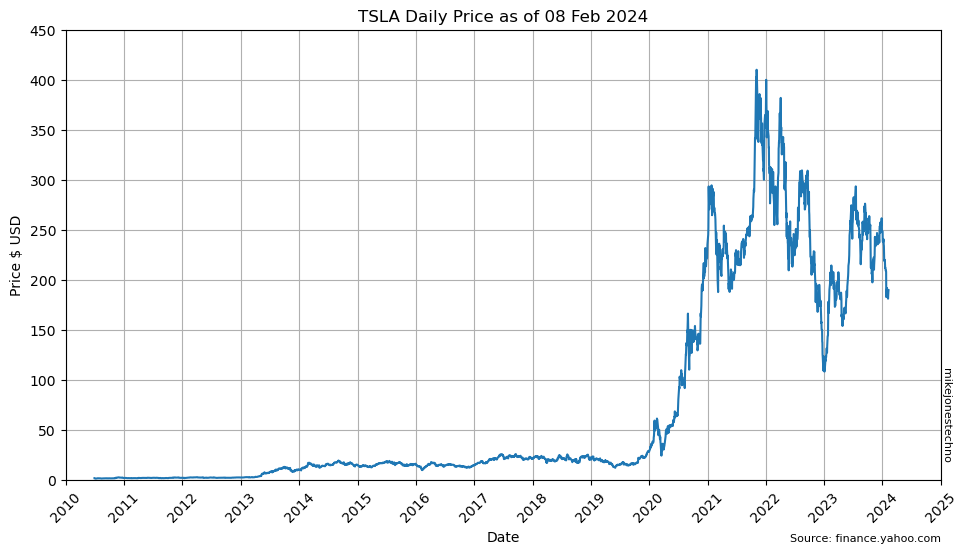

In [5]:
""" Show simple chart """

chart_params = {
    'chart_title': 'TSLA Daily Price as of ' + last_index.strftime('%d %b %Y'), 
    'chart_source': 'Source: finance.yahoo.com', 
    'y_label': 'Price $ USD', 
    'y_ticks': 50,
    'x_label': 'Date', 
    'x_ticks': 1,
    'data_column': data_column
}

standard_chart = StandardChart(**chart_params)
plt, colors = standard_chart.base_chart(df)

plt.plot(df.index, df[data_column], color=colors[0]['color'])

plt.show()

The compound annual growth over time appears to be exponential growth. Plotting the same data with a logarithmic y-axis scale helps visualize the bursts of growth in earlier years that would otherwise be hidden by the volatility of spikes in later years.

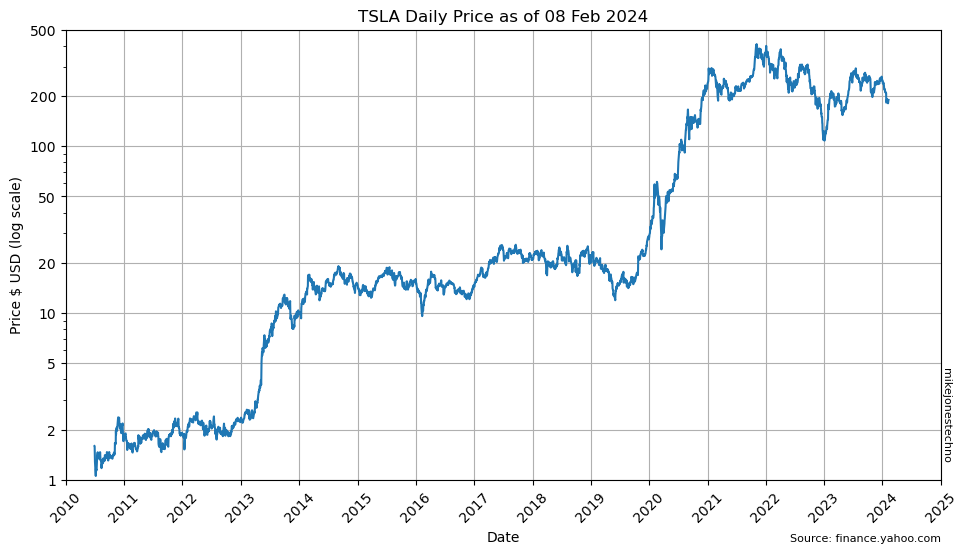

In [6]:
""" y-axis log scale """
log_chart_params = chart_params.copy()
log_chart_params['y_label'] = chart_params['y_label'] + ' (log scale)'
log_chart_params['y_ticks'] = [1, 2, 5, 10, 20, 50, 100, 200, 500]
log_chart = LogChart(**log_chart_params)
plt, colors = log_chart.base_chart(df)
plt.plot(df.index, df[data_column], color=colors[0]['color'])
plt.show()

The logarithmic scale shows the price was slightly increasing from IPO in 2010 to 2013 before a sudden 5x jump between 2013 and 2014 from $2 to $10 (split adjusted).

The jump was likely attributed to the Model S launch in 2012 and the first quarter of profit since the company was founded in 2003. The jump was followed by strong 2x growth in the five year period between 2014 and 2019, before another sudden 10x jump between 2020 and 2012 from $20 to $200 (split adjusted).

The second jump is likely attibuted to the Model 3 production ramp, and the final validation of Tesla as a profitable auto maker at scale, although at this price Tesla exceeds the market capitalization of the top eight global auto makers... combined.

The price has been highly volatile since 2021 generally trending sideways.

For comparison, the high performance S&P 500 Index only shows 5x growth over a ten year or longer period. The 100x growth in ten years from 2011 to 2021 is "rare".

In [7]:
""" Year over Year (YoY) change based on 252 trading days per year """
annual_trading_days = 252
df['YoY'] = df[data_column].pct_change(periods=annual_trading_days)*100

""" Calculate median 50th and lower, upper percentiles over multiple years """
periods_per_year = annual_trading_days
multi_years = [5, 10]

# Define the percentiles and window sizes
Percentiles = namedtuple('Percentiles', ['lower', 'median', 'upper'])
percentiles = Percentiles(25, 50, 75)

window_periods = [
    periods_per_year,
    periods_per_year * multi_years[0],
    periods_per_year * multi_years[1],
]

def add_percentiles(df, column, window, prefix):
    """Calculate and add percentiles to the DataFrame for a given window size."""
    for percentile_name, percentile in zip(percentiles._fields, percentiles):
        df[f'{prefix}_{percentile_name}'] = df[column].rolling(window=window).quantile(percentile/100)

# Calculate and add the percentiles for each window size
for window in window_periods:
    years = window // periods_per_year
    name = f'rolling_{years}_years'
    add_percentiles(df, 'YoY', window, name)

In [8]:
""" Create a markdown data table of the multi year percentiles to reuse in other notebooks """

# Create the header rows of the table
table = "| Years |   " + " |   ".join(f'{str(percentile)}' for percentile in percentiles) + " |\n"
table += "|-------" + "|-----:" * len(Percentiles._fields) + "|\n"

# Add the percentile values for each window period
for window in window_periods:
    years = window // periods_per_year
    name = f'rolling_{years}_years'
    table += f"| {str(years).ljust(5)} | " + " | ".join("{:,.2f}".format(df[f'{name}_{percentile_name}'].iloc[-1]) for percentile_name in Percentiles._fields) + " |\n"

In [9]:
display(Markdown(f"""
Calculating the {percentiles[0]}th and {percentiles[2]}th percentile over a multi-year time horizon helps smooth out the anomolies and visualize the {Percentiles._fields[0]} and {Percentiles._fields[2]} long term trends.
"""))


Calculating the 25th and 75th percentile over a multi-year time horizon helps smooth out the anomolies and visualize the lower and upper long term trends.


In [10]:
# Replace headings for percentile column headings
headings = table.split('\n')[0].split('|')[2:-1]
updated_headings = [ heading.strip() + 'th percentile' for heading in headings]
updated_headings_row = '| Years | ' + ' | '.join(updated_headings) + ' |'
show_table = table.replace(table.split('\n')[0], updated_headings_row, 1)

display(Markdown(f"""
Over the last {multi_years[0]} years the {Percentiles._fields[1]} ({percentiles[1]}th percetile) change is { "{:,.2f}".format(df[f'rolling_{multi_years[0]}_years_{Percentiles._fields[1]}'].iloc[-1])  }%.

Over the last {multi_years[-1]} years the {Percentiles._fields[1]} ({percentiles[1]}th percetile) change is { "{:,.2f}".format(df[f'rolling_{multi_years[-1]}_years_{Percentiles._fields[1]}'].iloc[-1])  }%.

{show_table}
"""))


Over the last 5 years the median (50th percetile) change is 25.15%.

Over the last 10 years the median (50th percetile) change is 18.64%.

| Years | 25th percentile | 50th percentile | 75th percentile |
|-------|-----:|-----:|-----:|
| 1     | -29.18 | -7.06 | 18.79 |
| 5     | -12.77 | 25.15 | 173.34 |
| 10    | -9.46 | 18.64 | 76.97 |



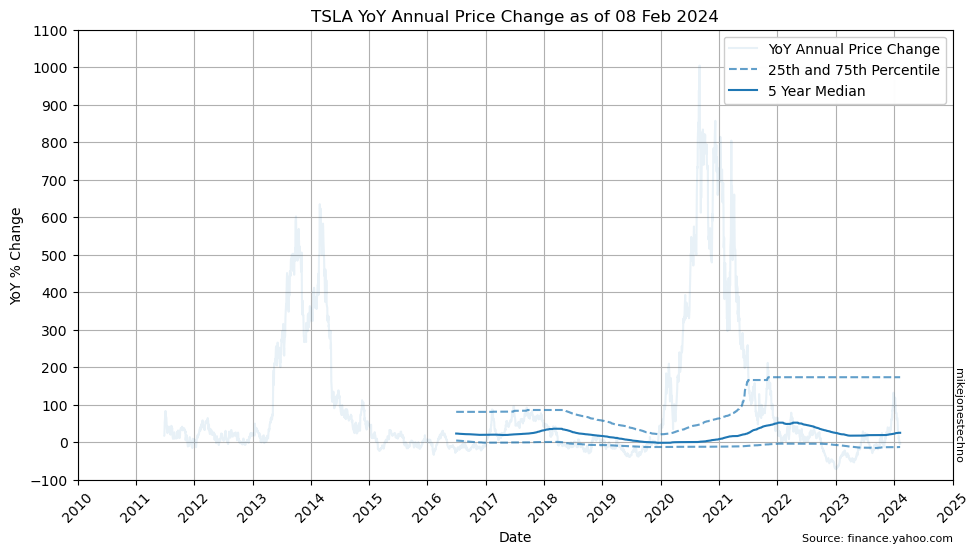

In [11]:
chart_params['chart_title'] = 'TSLA YoY Annual Price Change as of ' + last_index.strftime('%d %b %Y')
chart_params['data_column'] = 'YoY'
chart_params['x_ticks'] = 1
chart_params['y_label'] = 'YoY % Change'
chart_params['y_ticks'] = 100
chart_params['color_index'] = 0
percentile_chart = PercentileChart(percentiles, multi_years[0], **chart_params)
percentile_chart.plot_percentiles(df) 

> ℹ Given the multi-decade history, the data suggests high confidence using a baseline stock market performance of 11.5% with some uncertainty or risk that stocks can go up or down for several years at a time. Note this does not take inflation into consideration.

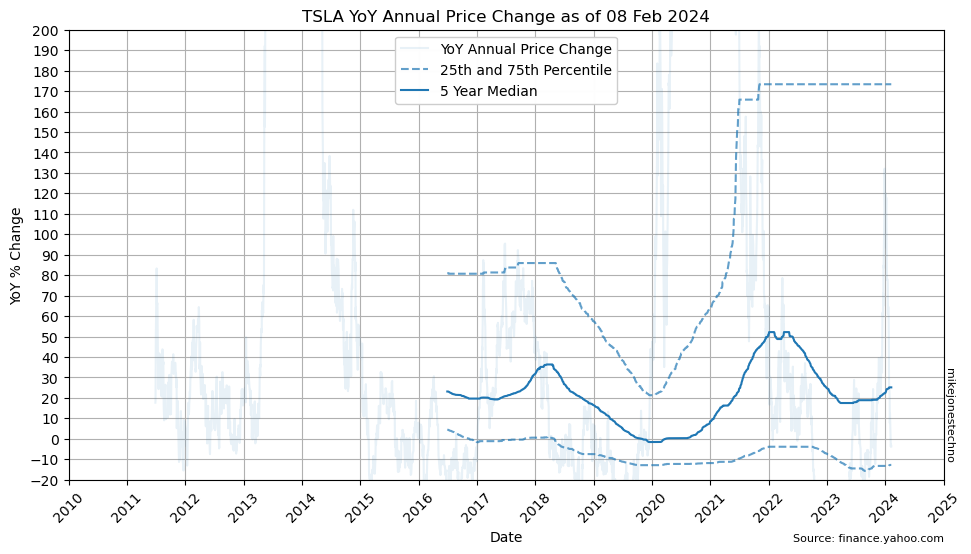

In [12]:
""" Change chart variables to plot from 1995 and multi year window not extended multi year window """
chart_params['x_ticks'] = 1
chart_params['y_ticks'] = 10
chart_params['bottom_limit'] = -20
chart_params['top_limit'] = 200
percentile_chart = PercentileChart(percentiles, multi_years[0], **chart_params)
percentile_chart.plot_percentiles(df)

In [13]:
## TODO: Add an overlay of inflation - super funds often set a target of 2.5 - 3.5% above inflation 10 year average
## TODO: Add opinion on the relative strong performance of S&P 500, and inclusion of high profit stocks, regardless of personal ethics or values? 